In [ ]:
!pip install nibabel -q
!pip install scikit-learn -q
!pip install tifffile -q
!pip install tqdm -q
!pip install split-folders -q
!pip install torchinfo -q
!pip install segmentation-models-pytorch-3d -q
!pip install livelossplot -q
!pip install torchmetrics -q
!pip install tensorboard -q

In [ ]:
import os
import random
import splitfolders
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time

from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from torch.cuda import amp

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import gc

import segmentation_models_pytorch_3d as smp

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

In [ ]:
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 5
    EPOCHS:          int = 100
    LEARNING_RATE: float = 1e-3
    CHECKPOINT_DIR:  str = os.path.join('model_checkpoint', '3D_UNet_Brats2023')
    NUM_WORKERS:     int = 4

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, normalization=True):
        super().__init__()

        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_list = sorted(os.listdir(img_dir))  # Ensure sorting to match images and masks
        self.mask_list = sorted(os.listdir(mask_dir))
        self.normalization = normalization

        # If normalization is True, set up a normalization transform
        if self.normalization:
            self.normalizer = transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust mean and std based on your data

    def load_file(self, filepath):
        return np.load(filepath)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.img_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        # Load the image and mask
        image = self.load_file(image_path)
        mask = self.load_file(mask_path)

        # Convert to torch tensors and permute axes to C, D, H, W format (needed for 3D models)
        image = torch.from_numpy(image).permute(3, 2, 0, 1)  # Shape: C, D, H, W
        mask = torch.from_numpy(mask).permute(3, 2, 0, 1)  # Shape: C, D, H, W

        # Normalize the image if normalization is enabled
        if self.normalization:
            image = self.normalizer(image)

        return image, mask

In [ ]:
train_img_dir = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/train/images"
train_mask_dir = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/train/masks"


val_img_dir = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/val/images"
val_mask_dir = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/val/masks"

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)


# Initialize datasets with normalization only
train_dataset = BraTSDataset(train_img_dir, train_mask_dir, normalization=True)
val_dataset = BraTSDataset(val_img_dir, val_mask_dir, normalization=True)

# Print dataset statistics
print("Total Training Samples: ", len(train_dataset))
print("Total Val Samples: ", len(val_dataset))

Total Training Samples:  33
Total Val Samples:  9


In [ ]:
%%time


print("Total Training Samples: ", len(train_dataset))
print("Total Val Samples: ", len(val_dataset))


train_loader = DataLoader(train_dataset, batch_size = 5, shuffle = True, num_workers = 14)
val_loader = DataLoader(val_dataset, batch_size = 5, shuffle = False, num_workers = 14)



#Sanity Check
images, masks = next(iter(train_loader))
print(f"Train Image batch shape: {images.shape}")
print(f"Train Mask batch shape: {masks.shape}")


#Sanity Check
images, masks = next(iter(val_loader))
print(f"Val Image batch shape: {images.shape}")
print(f"Val Mask batch shape: {masks.shape}")

Total Training Samples:  33
Total Val Samples:  9


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Image batch shape: torch.Size([5, 3, 128, 128, 128])
Train Mask batch shape: torch.Size([5, 4, 128, 128, 128])
Val Image batch shape: torch.Size([5, 3, 128, 128, 128])
Val Mask batch shape: torch.Size([5, 4, 128, 128, 128])
CPU times: user 74.8 ms, sys: 1.18 s, total: 1.26 s
Wall time: 40.1 s


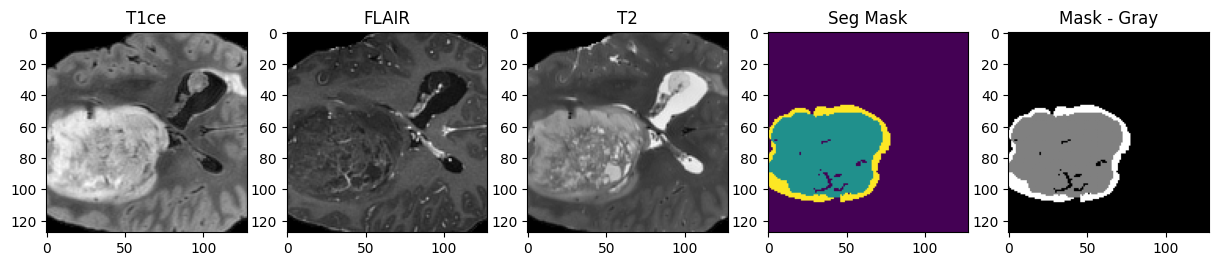

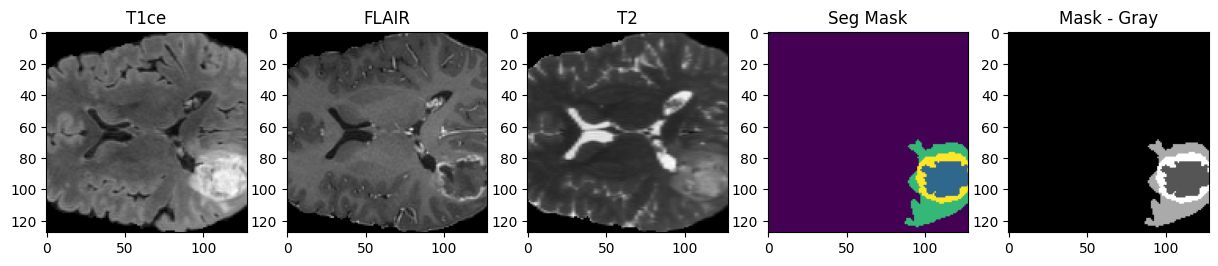

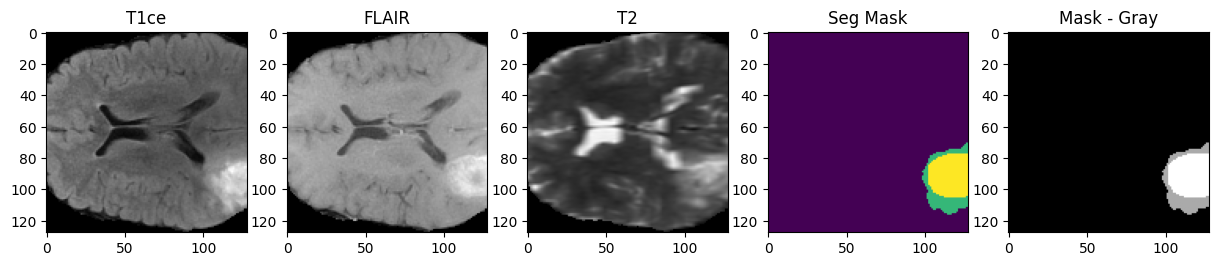

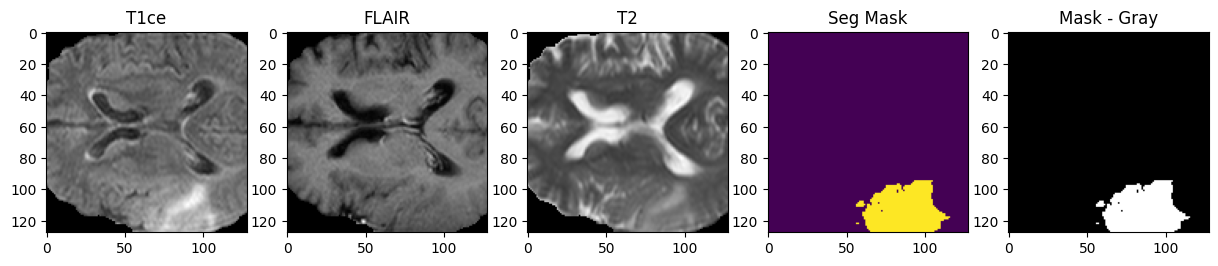

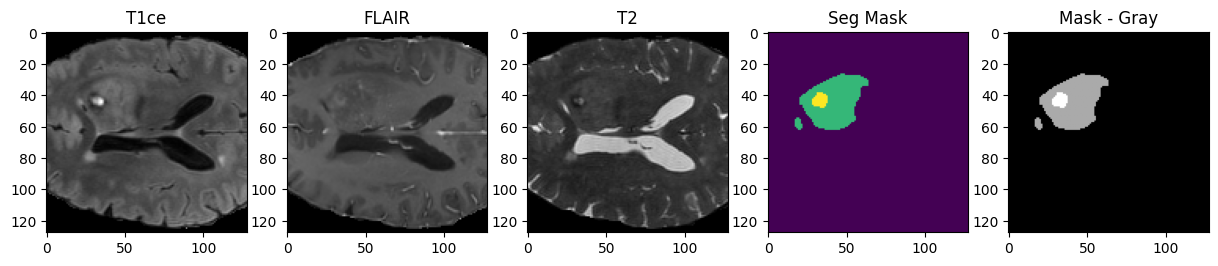

In [ ]:
def visualize_slices(images, masks, num_slices=20):
    batch_size = images.shape[0]

    masks = torch.argmax(masks, dim=1) #along the channel/class dim

    for i in range(min(num_slices, batch_size)):
        fig,ax = plt.subplots(1,5,figsize = (15,5))

        middle_slice = images.shape[2] // 2
        ax[0].imshow(images[i,0, middle_slice,:,:], cmap = 'gray')
        ax[1].imshow(images[i, 1, middle_slice, : ,:], cmap = 'gray')
        ax[2].imshow(images[i, 2, middle_slice, :, :], cmap = 'gray')
        ax[3].imshow(masks[i, middle_slice, : ,:], cmap = 'viridis')
        ax[4].imshow(masks[i, middle_slice, : ,:], cmap = 'gray')


        ax[0].set_title('T1ce')
        ax[1].set_title('FLAIR')
        ax[2].set_title('T2')
        ax[3].set_title('Seg Mask')
        ax[4].set_title('Mask - Gray')

        plt.show()

visualize_slices(images, masks, num_slices = 20)

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),  # Add BatchNorm3d after convolution
        nn.ReLU(inplace=True),
        nn.Dropout(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),  # Add BatchNorm3d after second convolution
        nn.ReLU(inplace=True)
    )

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Contraction path
        self.conv1 = double_conv(in_channels=in_channels, out_channels=16)
        self.pool1 = nn.MaxPool3d(kernel_size=2)

        self.conv2 = double_conv(in_channels=16, out_channels=32)
        self.pool2 = nn.MaxPool3d(kernel_size=2)

        self.conv3 = double_conv(in_channels=32, out_channels=64)
        self.pool3 = nn.MaxPool3d(kernel_size=2)

        self.conv4 = double_conv(in_channels=64, out_channels=128)
        self.pool4 = nn.MaxPool3d(kernel_size=2)

        self.conv5 = double_conv(in_channels=128, out_channels=256)

        # Expansive path
        self.upconv6 = nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv6 = double_conv(in_channels=256, out_channels=128)

        self.upconv7 = nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.conv7 = double_conv(in_channels=128, out_channels=64)

        self.upconv8 = nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.conv8 = double_conv(in_channels=64, out_channels=32)

        self.upconv9 = nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.conv9 = double_conv(in_channels=32, out_channels=16)

        self.out_conv = nn.Conv3d(in_channels=16, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)  # downscale

        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)  # upscale
        u6 = torch.cat([u6, c4], dim=1)  # skip connections along channel dim
        c6 = self.conv6(u6)

        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)

        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)

        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        outputs = self.out_conv(c9)

        return outputs


# Test the model
model = UNet3D(in_channels=3, out_channels=4)
print(model)

# Create a random input tensor
ip_tensor = torch.randn(1, 3, 128, 128, 128)

# Forward pass through the model
output = model(ip_tensor)

# Print input and output shapes
print("-" * 260)
print(f"Input shape: {ip_tensor.shape}")
print(f"Output shape: {output.shape}")

UNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
DEVICE, GPU_AVAILABLE = get_default_device()

trained_model = UNet3D(in_channels = 3, out_channels = 4)

trained_model.load_state_dict(torch.load("/content/drive/MyDrive/3D_U-Net_BraTS_ckpt.tar", map_location = "cpu")['model'])

trained_model.to(DEVICE)
trained_model.eval()

UNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
import torch, numpy as np, nibabel as nib, os

# ------------- EDIT to your sample loader -------------
# Your sample should be the exact tensor you feed into the model
# (before .to(device)). For example, if you build x from 3 .npy files:
def load_sample_tensor(img_npy_path):  # img: H,W,D,C expected by training
    arr = np.load(img_npy_path)            # (H,W,D,C) in training pipeline
    ten = torch.from_numpy(arr).permute(3,2,0,1).float()  # -> (C,D,H,W)
    return ten

# Example placeholders:
img_path = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/val/images/image_10.npy"
msk_path = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/val/masks/mask_10.npy"

x = load_sample_tensor(img_path)            # (C,D,H,W)
y = torch.from_numpy(np.load(msk_path)).permute(3,2,0,1).float()  # one-hot (C,D,H,W)

# If your pipeline already builds a batch tensor `xb` that you pass to model,
# set:  x = xb[0].cpu()

# ------------- Checks start here ----------------------

# 1) Modality count/order
print(">> EXPECT image channels: 3 in order [T1ce, FLAIR, T2]")
print("Input tensor shape (C,D,H,W):", tuple(x.shape))
assert x.ndim == 4 and x.shape[0] == 3, "Model was trained for 3 input channels!"

# 2) Spatial size
print(">> EXPECT spatial size 128x128x128")
print("Spatial (D,H,W):", tuple(x.shape[1:]))
assert list(x.shape[1:]) == [128,128,128], "Expected 128^3 volumes"

# 3) Intensity distribution
# this training used Normalize(mean=0.5,std=0.5) on ~0..1 inputs -> roughly -1..+1 after Normalize inside Dataset.
# Here we print BEFORE Normalize to see if you are near 0..1
for c,name in enumerate(["T1ce","FLAIR","T2"]):
    v = x[c]
    nz = v[v!=0]
    print(f"ch{c} {name}  min/max [{v.min():.3f},{v.max():.3f}]  nz_mean {nz.mean():.3f} nz_std {nz.std():.3f}")

# 4) Label shape + encoding
print(">> EXPECT one-hot mask with 4 channels (C,D,H,W)")
print("Mask shape:", tuple(y.shape))
assert y.ndim == 4 and y.shape[0] == 4, "Training used 4-class one-hot masks"

# Confirm hard one-hot (0/1)
unique_vals = torch.unique(y)
print("Mask unique values:", unique_vals[:10])
assert float(unique_vals.max()) <= 1.0 and float(unique_vals.min()) >= 0.0, "Mask should be 0/1 one-hot"

# 5) Architecture↔weights match
try:
    from inspect import signature
    print("Model in_channels:", getattr(model, "in_channels", "unknown"))
    # try a forward on a single-item batch
    with torch.no_grad():
        yhat = model(x.unsqueeze(0).to(next(model.parameters()).device).float())
    print("Model output shape (B,C,D,H,W):", tuple(yhat.shape))
    assert yhat.shape[1] == 4, "Model must output 4 logits (4 classes)"
except Exception as e:
    print("Forward test FAILED:", e)

# 6) Orientation/spacing — if you have original NIfTI paths, print axcodes/zooms
# (Skip if you're only using .npy)
def nifti_info(path):
    try:
        ni = nib.load(path)
        print("Axcodes:", nib.aff2axcodes(ni.affine), "zooms:", ni.header.get_zooms())
    except Exception as e:
        print("NIfTI check skipped:", e)

# Example: nifti_info("/content/.../T1ce.nii.gz")


>> EXPECT image channels: 3 in order [T1ce, FLAIR, T2]
Input tensor shape (C,D,H,W): (3, 128, 128, 128)
>> EXPECT spatial size 128x128x128
Spatial (D,H,W): (128, 128, 128)
ch0 T1ce  min/max [0.000,1.000]  nz_mean 0.473 nz_std 0.192
ch1 FLAIR  min/max [0.000,1.000]  nz_mean 0.181 nz_std 0.074
ch2 T2  min/max [0.000,1.000]  nz_mean 0.302 nz_std 0.136
>> EXPECT one-hot mask with 4 channels (C,D,H,W)
Mask shape: (4, 128, 128, 128)
Mask unique values: tensor([0., 1.])
Model in_channels: unknown
Model output shape (B,C,D,H,W): (1, 4, 128, 128, 128)


In [ ]:
# 1) STRICT load and SHOW what we loaded
import torch, os

ckpt_path = "/content/drive/MyDrive/3D_U-Net_BraTS_ckpt.tar"  # <-- your file
assert os.path.exists(ckpt_path), f"Missing checkpoint: {ckpt_path}"

ckpt = torch.load(ckpt_path, map_location="cpu")

# Your model class must be the same one used in training:
model = UNet3D(in_channels=3, out_channels=4)  # same depth/filters as training

missing, unexpected = model.load_state_dict(ckpt["model"], strict=False)
print("STATE LOAD -> missing:", len(missing), "unexpected:", len(unexpected))
print("EPOCH:", ckpt.get("epoch"), "BEST_IOU:", ckpt.get("best_iou"))

# 2) Make it fail loudly if there’s any mismatch
assert len(missing)==0 and len(unexpected)==0, \
    f"Checkpoint/model mismatch. Missing={missing[:5]} Unexpected={unexpected[:5]}"

# 3) Quick sanity of first conv stats (non-random weights shouldn’t be ~0 or NaN)
first_key = [k for k in model.state_dict().keys() if "weight" in k][0]
w = model.state_dict()[first_key].float()
print("First conv weight mean/std:", float(w.mean()), float(w.std()))


STATE LOAD -> missing: 0 unexpected: 0
EPOCH: None BEST_IOU: None
First conv weight mean/std: -0.004525111056864262 0.09179714322090149


In [ ]:
import torch.nn.functional as F
import numpy as np

# path to one of your preprocessed validation volumes (.npy)
img_path = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/val/images/image_10.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
x = torch.from_numpy(np.load(img_path)).permute(3,2,0,1).unsqueeze(0).float().to(device)
print("x shape:", x.shape)   # should print torch.Size([1, 3, 128, 128, 128])

model.eval()
model.to(device) # Move model to the device

def forward_once(x):
    with torch.no_grad():
        x_norm = (x - 0.5) / 0.5
        logits = model(x_norm)
        prob = F.softmax(logits, dim=1)
        ent  = -(prob * (prob.clamp_min(1e-7).log())).sum(dim=1)
        mean_ent = float(ent.mean())
        pred = prob.argmax(dim=1)
    return logits, prob, pred, mean_ent

logits, prob, pred, mean_ent = forward_once(x)

print("Softmax class mass (global):", [float(prob[:,i].mean()) for i in range(4)])
print("Mean entropy:", mean_ent)
print("Predicted class histogram:", torch.bincount(pred.view(-1), minlength=4).cpu().tolist())

Using device: cuda
x shape: torch.Size([1, 3, 128, 128, 128])
Softmax class mass (global): [0.8761826157569885, 0.08173901587724686, 0.0407877117395401, 0.0012907061027362943]
Mean entropy: 0.012998287566006184
Predicted class histogram: [1837481, 172001, 85100, 2570]


PAIR: image_10.npy mask_10.npy
Chosen slice z: 80   GT area: 5482


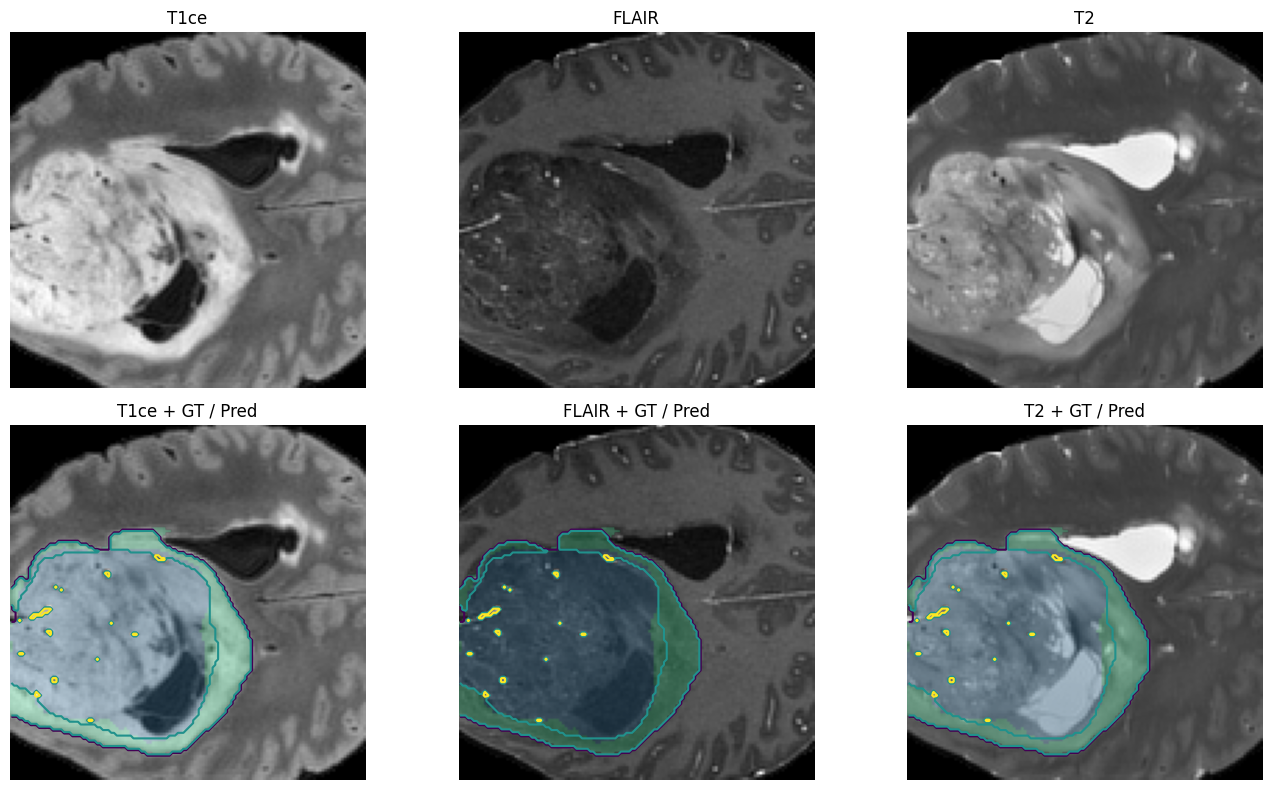

Dice [bg, c1, c2, c3]: ['0.997', '0.937', '0.849', '0.064']
WT Dice (c1|c2|c3 vs >0): 0.981
Best flip (whole tumor): ('none', 0.9807275285307966)


In [ ]:
import numpy as np, torch

img_path = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/val/images/image_10.npy"
msk_path = "/content/drive/MyDrive/BraTS2023_Preprocessed/input_data_128/val/masks/mask_10.npy"

im_np = np.load(img_path)         # (H,W,D,C=3)  order: [T1ce, FLAIR, T2]
msk_np = np.load(msk_path)        # (H,W,D,C=4)  one-hot

# tensors used for model:
x = torch.from_numpy(im_np).permute(3,2,0,1).unsqueeze(0).float()  # (1,3,D,H,W)
y = torch.from_numpy(msk_np).permute(3,2,0,1).float()              # (4,D,H,W)
gt_idx = y.argmax(0)                                                # (D,H,W)

print("PAIR:", img_path.split("/")[-1], msk_path.split("/")[-1])
assert img_path.split("/")[-1].replace("images","")\
       .replace("image","").split(".")[0] == msk_path.split("/")[-1].replace("masks","")\
       .replace("mask","").split(".")[0], "Image/Mask filename mismatch!"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

with torch.no_grad():
    logits = model(((x.to(device)-0.5)/0.5))
pred_idx = logits.argmax(1).cpu()[0]   # (D,H,W)
import numpy as np

areas = [(gt_idx[z]>0).sum().item() for z in range(gt_idx.shape[0])]
z = int(np.argmax(areas))     # axial slice with largest GT tumor area

print("Chosen slice z:", z, "  GT area:", areas[z])

import numpy as np, matplotlib.pyplot as plt

# im_np: (H,W,D,C=3)  -> [T1ce, FLAIR, T2]
# gt_idx, pred_idx: (D,H,W)
# choose a slice (you already computed `z` as max-area; reuse that)
mods  = ["T1ce","FLAIR","T2"]
imgs  = [im_np[...,0], im_np[...,1], im_np[...,2]]  # (H,W,D) each

plt.figure(figsize=(14,8))

# Row 1: raw modalities
for i,(name,img3d) in enumerate(zip(mods, imgs)):
    plt.subplot(2,3,i+1)
    plt.title(name); plt.axis("off")
    plt.imshow(img3d[:,:,z], cmap="gray")

# Row 2: overlays on the same modalities
# (use semi-transparent color overlay for GT and Pred)
for i,(name,img3d) in enumerate(zip(mods, imgs)):
    plt.subplot(2,3,3+i+1)
    plt.title(f"{name} + GT / Pred"); plt.axis("off")
    plt.imshow(img3d[:,:,z], cmap="gray")
    # GT overlay
    gt_ov = np.ma.masked_where(gt_idx[z]==0, gt_idx[z])
    plt.imshow(gt_ov, alpha=0.35, vmin=0, vmax=3)   # GT in color
    # Pred contour (thin outline)
    plt.contour(pred_idx[z], levels=[0.5,1.5,2.5], linewidths=1.5)

plt.tight_layout(); plt.show()


def dice_per_class(pred, gt, c):
    p = (pred==c); g = (gt==c)
    inter = (p & g).sum().item()
    d = (2*inter) / (p.sum().item() + g.sum().item() + 1e-8)
    return d

dice = [dice_per_class(pred_idx, gt_idx, c) for c in range(4)]
print("Dice [bg, c1, c2, c3]:", [f"{d:.3f}" for d in dice])
print("WT Dice (c1|c2|c3 vs >0):",
      f"{(2*((pred_idx>0)&(gt_idx>0)).sum().item())/((pred_idx>0).sum().item()+(gt_idx>0).sum().item()+1e-8):.3f}")

def best_flip_dice(pred, gt):
    variants = {
        "none": pred,
        "flipD": pred.flip(0),
        "flipH": pred.flip(1),
        "flipW": pred.flip(2),
        "flipDH": pred.flip(0).flip(1),
        "flipDW": pred.flip(0).flip(2),
        "flipHW": pred.flip(1).flip(2),
        "flipDHW": pred.flip(0).flip(1).flip(2),
    }
    best = ("none", -1)
    for k, v in variants.items():
        d = (2*((v>0)&(gt>0)).sum().item())/((v>0).sum().item()+(gt>0).sum().item()+1e-8)
        if d > best[1]: best = (k, d)
    return best

print("Best flip (whole tumor):", best_flip_dice(pred_idx, gt_idx))


Using device: cuda
Checkpoint loaded (strict=True).


Batches:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3889576754.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and device.type=="cuda")):
Batches: 100%|██████████| 2/2 [00:20<00:00, 10.36s/it]


Saved CSV: /content/inference_results_final/inference_metrics.csv
Saved global confusion matrix to: /content/inference_results_final/global_confusion_matrix.csv
Inference finished. Cases processed: 9
Average WT Dice (per-case mean): 0.9231
Voxel-level accuracy: 0.9907  | Macro-F1 (per-class): 0.9123
Dice per class (from cm): ['0.9965', '0.9302', '0.8576', '0.8650']
Global confusion matrix (rows=true, cols=pred):
 [[17890877     1306    28791     2124]
 [     640   220897     9714     8372]
 [   91593    10463   480294    10208]
 [    1132     2643     8783   106531]]
Total time: 20.79 seconds



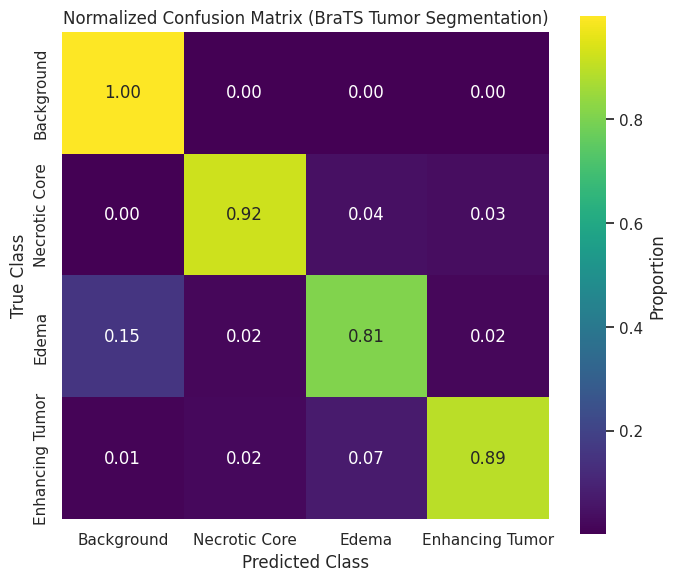

✅ Confusion matrix plot saved to: /content/inference_results_final/confusion_matrix_normalized.png


In [ ]:
# ===== INFERENCE CELL (HD95 REMOVED) =====
# On-the-fly GPU-friendly evaluation: saves clean overlays + per-case CSV + global confusion matrix
import os, time, shutil, csv, gc
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
CKPT_PATH = "/content/drive/MyDrive/3D_U-Net_BraTS_ckpt.tar"
OUT_DIR   = "/content/inference_results_final"
PRED_DIR  = os.path.join(OUT_DIR, "pred_masks")
QC_DIR    = os.path.join(OUT_DIR, "qc_overlays")
CSV_PATH  = os.path.join(OUT_DIR, "inference_metrics.csv")
# Change global confusion matrix file extension to .csv
GLOBAL_CM_PATH = os.path.join(OUT_DIR, "global_confusion_matrix.csv")

USE_AMP = True         # use AMP on GPU if available
SAVE_PRED = True

# Remove previous outputs and recreate folders
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)
os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(QC_DIR, exist_ok=True)

# ---------- device & model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

assert os.path.exists(CKPT_PATH), f"Missing checkpoint: {CKPT_PATH}"
ckpt = torch.load(CKPT_PATH, map_location="cpu")
model = UNet3D(in_channels=3, out_channels=4)   # ensure UNet3D exists in notebook
try:
    model.load_state_dict(ckpt["model"], strict=True)
    print("Checkpoint loaded (strict=True).")
except Exception as e:
    print("Strict load failed, fallback to non-strict:", e)
    model.load_state_dict(ckpt["model"], strict=False)
model = model.to(device).eval()
torch.cuda.empty_cache()

# ---------- small helpers ----------
def safe_dice(pred, gt, c):
    p = (pred == c); g = (gt == c)
    inter = int((p & g).sum()); denom = int(p.sum()) + int(g.sum())
    if denom == 0:
        return 1.0 if inter == 0 else 0.0
    return float((2.0 * inter) / (denom + 1e-8))

def safe_wt(pred, gt):
    p = (pred > 0); g = (gt > 0)
    inter = int((p & g).sum()); denom = int(p.sum()) + int(g.sum())
    if denom == 0:
        return 1.0 if inter == 0 else 0.0
    return float((2.0 * inter) / (denom + 1e-8))

# ---------- prepare global confusion matrix (on GPU) ----------
NUM_CLASSES = 4
cm_total = torch.zeros(NUM_CLASSES * NUM_CLASSES, dtype=torch.long, device=device)  # flattened

# ---------- main inference loop ----------
results = []
case_counter = 0
t0 = time.time()

for batch_idx, (batch_img, batch_mask) in enumerate(tqdm(val_loader, desc="Batches")):
    # move to device
    batch_img = batch_img.to(device, dtype=torch.float32, non_blocking=True)
    batch_mask = batch_mask.to(device, dtype=torch.float32, non_blocking=True)

    # per-volume normalization if needed
    mn = batch_img.amin(dim=(2,3,4), keepdim=True)
    mx = batch_img.amax(dim=(2,3,4), keepdim=True)
    batch_img = (batch_img - mn) / (mx - mn + 1e-8)

    x_norm = (batch_img - 0.5) / 0.5

    # forward (AMP optional)
    with torch.cuda.amp.autocast(enabled=(USE_AMP and device.type=="cuda")):
        logits = model(x_norm)

    # get predictions & gt label maps
    pred_batch = logits.argmax(1)          # (B,D,H,W) on device
    gt_batch    = batch_mask.argmax(1).to(device=device, dtype=torch.long)   # keep on device

    # update global confusion matrix (GPU) using flattened bincount trick
    K = NUM_CLASSES
    keys = (gt_batch * K + pred_batch).view(-1)
    binc = torch.bincount(keys, minlength=K*K)
    cm_total += binc

    # move preds and imgs to CPU for saving overlays (one case at a time)
    pred_cpu = pred_batch.cpu().numpy()    # (B,D,H,W)
    gt_cpu   = gt_batch.cpu().numpy()      # (B,D,H,W)
    imgs_cpu = batch_img.cpu().numpy()     # (B,3,D,H,W) values in [0,1]

    B = pred_cpu.shape[0]
    for i in range(B):
        pred = pred_cpu[i]   # (D,H,W)
        gt   = gt_cpu[i]     # (D,H,W)
        D = pred.shape[0]

        # choose slice with max gt area (use middle if none)
        areas = [(gt[z] > 0).sum() for z in range(D)]
        z_choice = int(np.argmax(areas)) if max(areas) > 0 else D // 2

        # compute metrics (fast on numpy)
        dice_vals = [safe_dice(pred, gt, c) for c in range(NUM_CLASSES)]
        wt = safe_wt(pred, gt)

        # Append metrics FIRST
        results.append({
            "case_id": case_counter,
            "batch_idx": int(batch_idx),
            "dice_bg": float(dice_vals[0]),
            "dice_c1": float(dice_vals[1]),
            "dice_c2": float(dice_vals[2]),
            "dice_c3": float(dice_vals[3]),
            "wt_dice": float(wt),
            "z_slice": int(z_choice)
        })

        # Save predictions
        if SAVE_PRED:
            np.save(os.path.join(PRED_DIR, f"case_{case_counter:04d}_pred.npy"), pred)
            np.save(os.path.join(PRED_DIR, f"case_{case_counter:04d}_gt.npy"), gt)

        # ---- Save clean overlay (no text) ----
        fig, ax = plt.subplots(1, 5, figsize=(18, 6))
        ax[0].imshow(imgs_cpu[i,0,z_choice], cmap="gray"); ax[0].set_title("T1ce"); ax[0].axis("off")
        ax[1].imshow(imgs_cpu[i,1,z_choice], cmap="gray"); ax[1].set_title("FLAIR"); ax[1].axis("off")
        ax[2].imshow(imgs_cpu[i,2,z_choice], cmap="gray"); ax[2].set_title("T2"); ax[2].axis("off")
        ax[3].imshow(gt[z_choice], cmap="viridis", vmin=0, vmax=3); ax[3].set_title("Ground Truth"); ax[3].axis("off")
        ax[4].imshow(pred[z_choice], cmap="viridis", vmin=0, vmax=3); ax[4].set_title("Predicted"); ax[4].axis("off")

        plt.tight_layout()
        out_png = os.path.join(QC_DIR, f"case_{case_counter:04d}_overlay_qc.png")
        fig.savefig(out_png, bbox_inches="tight", pad_inches=0.06, dpi=150)
        plt.close(fig)

        case_counter += 1

    # free batch memory
    del logits, pred_batch, gt_batch, pred_cpu, gt_cpu, imgs_cpu, keys, binc
    torch.cuda.empty_cache()
    gc.collect()

# Save CSV with all per-case metrics
if len(results) > 0:
    keys = list(results[0].keys())
    with open(CSV_PATH, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(results)
    print(f"Saved CSV: {CSV_PATH}")
else:
    print("Warning: no results to save.")

# FINAL: compute summary metrics from global confusion matrix
cm_flat = cm_total.cpu().numpy().reshape(NUM_CLASSES, NUM_CLASSES)
# Save confusion matrix as CSV
np.savetxt(GLOBAL_CM_PATH, cm_flat, delimiter=',', fmt='%d')
print("Saved global confusion matrix to:", GLOBAL_CM_PATH)

# derive metrics from cm
TP = np.diag(cm_flat).astype(float)
FP = cm_flat.sum(axis=0) - TP
FN = cm_flat.sum(axis=1) - TP
precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
f1 = 2 * precision * recall / (precision + recall + 1e-8)
accuracy = TP.sum() / cm_flat.sum() if cm_flat.sum() > 0 else float('nan')
macro_f1 = np.nanmean(f1)

print(f"Inference finished. Cases processed: {len(results)}")
print(f"Average WT Dice (per-case mean): {np.mean([r['wt_dice'] for r in results]):.4f}")
print(f"Voxel-level accuracy: {accuracy:.4f}  | Macro-F1 (per-class): {macro_f1:.4f}")
print("Dice per class (from cm):", [f"{d:.4f}" for d in f1])   # F1 ~= Dice for segmentation
print("Global confusion matrix (rows=true, cols=pred):\n", cm_flat)
print("Total time:", round(time.time() - t0, 2), "seconds")
print("")
# ===== CONFUSION MATRIX PLOT ONLY =====
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Config ----
OUT_DIR = "/content/inference_results_final"
# Load global confusion matrix from CSV
GLOBAL_CM_PATH = os.path.join(OUT_DIR, "global_confusion_matrix.csv")
SAVE_PATH = os.path.join(OUT_DIR, "confusion_matrix_normalized.png")

# ---- Load and plot ----
if not os.path.exists(GLOBAL_CM_PATH):
    raise FileNotFoundError(f"Global confusion matrix not found at {GLOBAL_CM_PATH}. Run inference first.")

# Load confusion matrix from CSV
cm = np.loadtxt(GLOBAL_CM_PATH, delimiter=',', dtype=int)
num_classes = cm.shape[0]

# Normalize rows (true class)
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-8)

# Define class labels (update as per your dataset)
class_labels = ["Background", "Necrotic Core", "Edema", "Enhancing Tumor"]

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar_kws={"label": "Proportion"},
    square=True
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix (BraTS Tumor Segmentation)")
plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=150, bbox_inches="tight")
plt.show()

print(f"✅ Confusion matrix plot saved to: {SAVE_PATH}")

In [ ]:
# ===== GENERATE CSV WITH ALL EVALUATION METRICS =====
import os, csv
import numpy as np
import pandas as pd

OUT_DIR = "/content/inference_results_final"
METRICS_CSV = os.path.join(OUT_DIR, "inference_metrics.csv")             # per-case results from inference
PRED_DIR    = os.path.join(OUT_DIR, "pred_masks")                        # saved per-case pred/gt npy
GLOBAL_CM   = os.path.join(OUT_DIR, "global_confusion_matrix.csv")       # saved by inference cell (now CSV)

OUT_PERCASE = os.path.join(OUT_DIR, "evaluation_metrics_per_case.csv")
OUT_GLOBAL  = os.path.join(OUT_DIR, "evaluation_metrics_global.csv")

if not os.path.exists(METRICS_CSV):
    raise FileNotFoundError(f"Missing per-case CSV: {METRICS_CSV}. Run inference cell first.")

df = pd.read_csv(METRICS_CSV)
df = df.sort_values("case_id").reset_index(drop=True)
num_cases = len(df)
print(f"Loaded {num_cases} per-case rows from {METRICS_CSV}")

# helper metric functions
eps = 1e-8
def per_confusion_metrics(conf):
    # conf: KxK numpy int array (rows=true, cols=pred)
    TP = np.diag(conf).astype(float)
    FP = conf.sum(axis=0) - TP
    FN = conf.sum(axis=1) - TP
    TN = conf.sum() - (TP + FP + FN)
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = TP / (TP + FP + FN + eps)
    accuracy = (TP.sum()) / (conf.sum() + eps)
    return {
        "precision_per_class": precision,
        "recall_per_class": recall,
        "f1_per_class": f1,
        "iou_per_class": iou,
        "accuracy": float(accuracy),
        "TP": TP.astype(int),
        "FP": FP.astype(int),
        "FN": FN.astype(int),
        "TN": TN.astype(int)
    }

# Per-case augmentation loop (reads pred/gt .npy per case)
rows_out = []
for _, row in df.iterrows():
    cid = int(row["case_id"])
    pred_path = os.path.join(PRED_DIR, f"case_{cid:04d}_pred.npy")
    gt_path   = os.path.join(PRED_DIR, f"case_{cid:04d}_gt.npy")
    if not (os.path.exists(pred_path) and os.path.exists(gt_path)):
        print(f"Warning: pred/gt missing for case {cid}, skipping advanced metrics for this case.")
        # preserve basic metrics from df row, but mark NAs
        out = row.to_dict()
        for k in ["prec_c0","prec_c1","prec_c2","prec_c3","rec_c0","rec_c1","rec_c2","rec_c3",
                  "f1_c0","f1_c1","f1_c2","f1_c3","iou_c0","iou_c1","iou_c2","iou_c3",
                  "accuracy_voxel","vol_c0_cm3","vol_c1_cm3","vol_c2_cm3","vol_c3_cm3","vol_WT_cm3"]:
            out[k] = np.nan
        rows_out.append(out)
        continue

    pred = np.load(pred_path).astype(np.int64)   # shape (D,H,W)
    gt   = np.load(gt_path).astype(np.int64)
    if pred.shape != gt.shape:
        print(f"Shape mismatch case {cid}: pred {pred.shape} vs gt {gt.shape}, skipping.")
        out = row.to_dict()
        for k in ["prec_c0","prec_c1","prec_c2","prec_c3","rec_c0","rec_c1","rec_c2","rec_c3",
                  "f1_c0","f1_c1","f1_c2","f1_c3","iou_c0","iou_c1","iou_c2","iou_c3",
                  "accuracy_voxel","vol_c0_cm3","vol_c1_cm3","vol_c2_cm3","vol_c3_cm3","vol_WT_cm3"]:
            out[k] = np.nan
        rows_out.append(out)
        continue

    # build confusion matrix per-case
    K = 4
    conf = np.zeros((K,K), dtype=np.int64)
    # flatten and bincount (safe memory for single case)
    gt_flat = gt.ravel()
    pred_flat = pred.ravel()
    idx = gt_flat * K + pred_flat
    binc = np.bincount(idx, minlength=K*K)
    conf = binc.reshape(K,K)

    metrics = per_confusion_metrics(conf)

    # volumes (voxels -> cm^3), assume voxel spacing 1x1x1 mm unless user has different spacing
    dz, dy, dx = (1.0,1.0,1.0)
    voxel_mm3 = dx * dy * dz
    mm3_to_cm3 = 1.0/1000.0
    vol_c = {}
    for c in range(K):
        vol_c[c] = int((pred_flat == c).sum()) * voxel_mm3 * mm3_to_cm3
    vol_WT = sum([v for k,v in vol_c.items() if k != 0])

    # assemble output row merging original row and new metrics
    out = row.to_dict()
    # precision/recall/f1/iou per class
    for c in range(K):
        out[f"prec_c{c}"] = float(metrics["precision_per_class"][c])
        out[f"rec_c{c}"] = float(metrics["recall_per_class"][c])
        out[f"f1_c{c}"]  = float(metrics["f1_per_class"][c])
        out[f"iou_c{c}"] = float(metrics["iou_per_class"][c])
        out[f"tp_c{c}"]  = int(metrics["TP"][c])
        out[f"fp_c{c}"]  = int(metrics["FP"][c])
        out[f"fn_c{c}"]  = int(metrics["FN"][c])
        out[f"tn_c{c}"]  = int(metrics["TN"][c])
    out["accuracy_voxel"] = float(metrics["accuracy"])
    out["vol_c0_cm3"] = float(vol_c[0])
    out["vol_c1_cm3"] = float(vol_c[1])
    out["vol_c2_cm3"] = float(vol_c[2])
    out["vol_c3_cm3"] = float(vol_c[3])
    out["vol_WT_cm3"] = float(vol_WT)

    rows_out.append(out)

# Write per-case augmented CSV
if len(rows_out) > 0:
    df_out = pd.DataFrame(rows_out)
    # order columns: existing ones first, then new metrics in sorted order
    existing = list(df.columns)
    extra = [c for c in df_out.columns if c not in existing]
    cols_final = existing + extra
    df_out = df_out[cols_final]
    df_out.to_csv(OUT_PERCASE, index=False)
    print(f"Saved per-case evaluation CSV: {OUT_PERCASE}")
else:
    print("No per-case rows produced; nothing saved.")

# Global metrics from global confusion matrix (if exists)
if os.path.exists(GLOBAL_CM):
    # Load confusion matrix from CSV
    cm = np.loadtxt(GLOBAL_CM, delimiter=',', dtype=int)
    K = cm.shape[0]
    TP = np.diag(cm).astype(float)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    iou = TP / (TP + FP + FN + eps)
    accuracy = TP.sum() / (cm.sum() + eps)
    rows_global = []
    for c in range(K):
        rows_global.append({
            "class": c,
            "precision": float(precision[c]),
            "recall": float(recall[c]),
            "f1": float(f1[c]),
            "iou": float(iou[c]),
            "tp": int(TP[c]),
            "fp": int(FP[c]),
            "fn": int(FN[c]),
            "tn": int(TN[c])
        })
    df_global = pd.DataFrame(rows_global)
    # also append a summary row
    df_global.loc["mean"] = df_global.mean(numeric_only=True)
    df_global.to_csv(OUT_GLOBAL, index=True)
    print(f"Saved global evaluation CSV: {OUT_GLOBAL}")
else:
    print("Global confusion matrix not found; skipping global CSV.")

# Print short previews
print("\nPer-case evaluation (first 5 rows):")
display(df_out.head().T)

if os.path.exists(OUT_GLOBAL):
    print("\nGlobal metrics (per-class):")
    display(df_global)

print("\nDone.")

Loaded 9 per-case rows from /content/inference_results_final/inference_metrics.csv
Saved per-case evaluation CSV: /content/inference_results_final/evaluation_metrics_per_case.csv
Saved global evaluation CSV: /content/inference_results_final/evaluation_metrics_global.csv

Per-case evaluation (first 5 rows):


0            1            2            3  \
case_id              0.0000       1.0000       2.0000       3.0000   
batch_idx            0.0000       0.0000       0.0000       0.0000   
dice_bg              0.9973       0.9981       0.9981       0.9978   
dice_c1              0.9366       0.9644       0.3685       1.0000   
dice_c2              0.8495       0.8856       0.8694       0.9241   
dice_c3              0.0644       0.8944       0.9430       0.0000   
wt_dice              0.9807       0.9392       0.9276       0.9240   
z_slice             80.0000      56.0000      52.0000      46.0000   
prec_c0              0.9982       0.9979       0.9985       0.9963   
rec_c0               0.9964       0.9984       0.9978       0.9993   
f1_c0                0.9973       0.9981       0.9981       0.9978   
iou_c0               0.9946       0.9962       0.9963       0.9955   
tp_c0          1834158.0000 2030505.0000 2040589.0000 2032667.0000   
fp_c0             3310.0000    4306.0000    3118.0000    7636.0000   
fn_c0             6644.0000    3338.0000    4520.0000    1470.0000   
tn_c0           253040.0000   59003.0000   48925.0000   55379.0000   
prec_c1              0.9333       0.9708       1.0000       0.0000   
rec_c1               0.9398       0.9580       0.2259       0.0000   
f1_c1                0.9366       0.9644       0.3685       0.0000   
iou_c1               0.8807       0.9312       0.2259       0.0000   
tp_c1           160537.0000    9978.0000      96.0000       0.0000   
fp_c1            11468.0000     300.0000       0.0000       0.0000   
fn_c1            10281.0000     437.0000     329.0000       0.0000   
tn_c1          1914866.0000 2086437.0000 2096727.0000 2097152.0000   
prec_c2              0.8505       0.9094       0.8414       0.9743   
rec_c2               0.8485       0.8630       0.8993       0.8788   
f1_c2                0.8495       0.8856       0.8694       0.9241   
iou_c2               0.7383       0.7947       0.7690       0.8589   
tp_c2            72382.0000   35915.0000   30694.0000   55379.0000   
fp_c2            12726.0000    3580.0000    5784.0000    1462.0000   
fn_c2            12926.0000    5700.0000    3436.0000    7636.0000   
tn_c2          1999118.0000 2051957.0000 2057238.0000 2032675.0000   
prec_c3              0.0350       0.8485       0.9603       0.0000   
rec_c3               0.4018       0.9455       0.9264       0.0000   
f1_c3                0.0644       0.8944       0.9430       0.0000   
iou_c3               0.0333       0.8089       0.8922       0.0000   
tp_c3               90.0000   10664.0000   16201.0000       0.0000   
fp_c3             2481.0000    1904.0000     670.0000       8.0000   
fn_c3              134.0000     615.0000    1287.0000       0.0000   
tn_c3          2094447.0000 2083969.0000 2078994.0000 2097144.0000   
accuracy_voxel       0.9857       0.9952       0.9954       0.9957   
vol_c0_cm3        1837.4680    2034.8110    2043.7070    2040.3030   
vol_c1_cm3         172.0050      10.2780       0.0960       0.0000   
vol_c2_cm3          85.1080      39.4950      36.4780      56.8410   
vol_c3_cm3           2.5710      12.5680      16.8710       0.0080   
vol_WT_cm3         259.6840      62.3410      53.4450      56.8490   

                          4  
case_id              4.0000  
batch_idx            0.0000  
dice_bg              0.9941  
dice_c1              0.1977  
dice_c2              0.8247  
dice_c3              0.6532  
wt_dice              0.8599  
z_slice             50.0000  
prec_c0              0.9921  
rec_c0               0.9960  
f1_c0                0.9941  
iou_c0               0.9882  
tp_c0          1999885.0000  
fp_c0            15905.0000  
fn_c0             8007.0000  
tn_c0            73355.0000  
prec_c1              0.5778  
rec_c1               0.1193  
f1_c1                0.1977  
iou_c1               0.1097  
tp_c1              104.0000  
fp_c1               76.0000  
fn_c1              768.0000  
tn_c1          


Global metrics (per-class):


class  precision  recall     f1    iou            tp         fp  \
0    0.0000     0.9948  0.9982 0.9965 0.9930 17890877.0000 93365.0000   
1    1.0000     0.9388  0.9219 0.9302 0.8696   220897.0000 14412.0000   
2    2.0000     0.9104  0.8105 0.8576 0.7506   480294.0000 47288.0000   
3    3.0000     0.8373  0.8945 0.8650 0.7621   106531.0000 20704.0000   
mean 1.5000     0.9203  0.9063 0.9123 0.8438  4674649.7500 43942.2500   

              fn            tn  
0     32221.0000   857905.0000  
1     18726.0000 18620333.0000  
2    112264.0000 18234522.0000  
3     12558.0000 18734575.0000  
mean  43942.2500 14111833.7500


Done.


In [ ]:
# Interactive case viewer: dropdown to pick case_id, show overlay image (no text) and metrics below
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets

# Paths (adjust if your folders differ)
OUT_DIR = "/content/inference_results_final"
QC_DIR  = os.path.join(OUT_DIR, "qc_overlays")
PRED_DIR = os.path.join(OUT_DIR, "pred_masks")
CSV_PATH = os.path.join(OUT_DIR, "inference_metrics.csv")

# Verify folders exist
if not os.path.isdir(OUT_DIR):
    raise FileNotFoundError(f"Output folder not found: {OUT_DIR}")
if not os.path.isdir(QC_DIR):
    print(f"Warning: QC folder not found: {QC_DIR} (PNG display will be skipped)")

# Load CSV metrics (if available) to populate dropdown and show metrics
df = None
if os.path.exists(CSV_PATH):
    try:
        df = pd.read_csv(CSV_PATH)
    except Exception:
        print("Warning: failed to load CSV metrics:", CSV_PATH)

# Build list of available case ids:
# Priority: use CSV case_id if present; else look for pred npy or qc png files.
case_ids = set()
if df is not None and "case_id" in df.columns:
    case_ids.update(int(x) for x in df["case_id"].tolist())

# scan pred masks and qc pngs for names like case_0000_...
for folder in (PRED_DIR, QC_DIR):
    if os.path.isdir(folder):
        for fname in os.listdir(folder):
            if fname.lower().endswith((".npy", ".png")) and fname.startswith("case_"):
                try:
                    cid = int(fname.split("_")[1])
                    case_ids.add(cid)
                except Exception:
                    pass

if len(case_ids) == 0:
    raise FileNotFoundError("No case files found in CSV/pred_masks/qc_overlays. Run inference first.")

case_ids = sorted(case_ids)

# Helper to resize and show PIL image cleanly (no text)
def show_image_only(pil_img, display_height=520):
    h = display_height
    w = int(pil_img.width * (h / pil_img.height))
    img_resized = pil_img.resize((w, h), Image.LANCZOS)
    plt.figure(figsize=(w/100, h/100))
    plt.imshow(img_resized)
    plt.axis("off")
    plt.show()

# The main renderer function
def render_case(case_id):
    clear_output(wait=True)
    print(f"Case selected: {case_id:04d}")
    png_path = os.path.join(QC_DIR, f"case_{case_id:04d}_overlay_qc.png")
    pred_npy = os.path.join(PRED_DIR, f"case_{case_id:04d}_pred.npy")
    gt_npy   = os.path.join(PRED_DIR, f"case_{case_id:04d}_gt.npy")

    displayed = False

    # 1) Prefer saved QC PNG
    if os.path.exists(png_path):
        try:
            pil = Image.open(png_path).convert("RGB")
            pil = ImageOps.expand(pil, border=6, fill=(255,255,255))
            show_image_only(pil)
            displayed = True
        except Exception as e:
            print("Failed to open QC PNG (will try reconstruction). Error:", e)

    # 2) If no png or failed: try reconstruct using pred/gt and image npy
    if not displayed:
        if os.path.exists(pred_npy) and os.path.exists(gt_npy):
            pred = np.load(pred_npy)  # (D,H,W)
            gt   = np.load(gt_npy)    # (D,H,W)

            # Search likely locations for the corresponding image_*.npy
            possible_img_dirs = [
                "/content/BraTS2023_Preprocessed/input_data_128/val/images",
                "/content/BraTS2023_Preprocessed/input_data_128/images",
                "/content/preprocessed/images",
                "/content/BraTS2023_Preprocessed/input_data_128/val",
                "."
            ]
            image_found = False
            im_np = None
            for d in possible_img_dirs:
                if not os.path.isdir(d):
                    continue
                # common naming patterns
                candidates = [
                    os.path.join(d, f"image_{case_id:04d}.npy"),
                    os.path.join(d, f"image_{case_id+1:04d}.npy"),
                    os.path.join(d, f"CASE_{case_id:04d}.npy"),
                    os.path.join(d, f"case_{case_id:04d}.npy"),
                ]
                for c in candidates:
                    if os.path.exists(c):
                        try:
                            im_np = np.load(c)
                            image_found = True
                            img_source = c
                            break
                        except Exception:
                            continue
                if image_found:
                    break

            # choose z slice (largest GT area)
            D = pred.shape[0]
            areas = [(gt[z] > 0).sum() for z in range(D)]
            z_choice = int(np.argmax(areas)) if max(areas) > 0 else D // 2

            if image_found and im_np is not None:
                # Normalize and build panels
                try:
                    # Accept im_np either (H,W,D,C) or (D,H,W,C) or (H,W,D,3)
                    if im_np.ndim == 4 and im_np.shape[2] == pred.shape[0]:
                        t1 = im_np[..., 0]; flair = im_np[..., 1]; t2 = im_np[..., 2]
                    elif im_np.ndim == 4 and im_np.shape[0] == pred.shape[0]:
                        # (D,H,W,C) -> transpose
                        im_np = np.transpose(im_np, (1,2,0,3))
                        t1 = im_np[...,0]; flair = im_np[...,1]; t2 = im_np[...,2]
                    else:
                        # fallback assume last dim is channels
                        t1 = im_np[...,0]; flair = im_np[...,1]; t2 = im_np[...,2]
                except Exception:
                    image_found = False

            if image_found:
                # convert grayscale to RGB panels
                def to_rgb(arr2d):
                    arr = (arr2d - float(arr2d.min())) / (float(arr2d.max()) - float(arr2d.min()) + 1e-8)
                    rgb = np.stack([arr, arr, arr], axis=-1)
                    rgb = (rgb * 255).astype(np.uint8)
                    return Image.fromarray(rgb)

                p0 = to_rgb(t1[:,:,z_choice]); p1 = to_rgb(flair[:,:,z_choice]); p2 = to_rgb(t2[:,:,z_choice])

                # mask to rgb (viridis with 4 discrete entries)
                import matplotlib.cm as cm
                cmap = cm.get_cmap("viridis", 4)
                def mask_to_rgb(mask2d):
                    norm = mask2d.astype(np.int32)
                    mapped = cmap(norm/3.0)[:,:,:3]
                    img = (mapped * 255).astype(np.uint8)
                    return Image.fromarray(img)

                p3 = mask_to_rgb(gt[z_choice]); p4 = mask_to_rgb(pred[z_choice])

                # resize panels to consistent height and join
                target_h = 480
                panels = [p.resize((int(p.width * (target_h / p.height)), target_h), Image.LANCZOS) for p in (p0,p1,p2,p3,p4)]
                total_w = sum(p.width for p in panels) + (len(panels)-1)*8
                canvas = Image.new("RGB", (total_w, target_h), (255,255,255))
                x = 0
                for p in panels:
                    canvas.paste(p, (x, 0))
                    x += p.width + 8

                show_image_only(canvas)
                displayed = True
            else:
                # fallback: show GT & Pred mid slice
                mid = gt.shape[0]//2
                fig, ax = plt.subplots(1,2,figsize=(10,5))
                ax[0].imshow(gt[mid], cmap='viridis', vmin=0, vmax=3); ax[0].axis('off'); ax[0].set_title('GT')
                ax[1].imshow(pred[mid], cmap='viridis', vmin=0, vmax=3); ax[1].axis('off'); ax[1].set_title('Pred')
                plt.show()
                displayed = True
        else:
            print("No saved QC PNG and no pred/gt npy found for this case.")
            print("Looked for PNG:", png_path)
            print("Looked for pred/gt:", pred_npy, gt_npy)

    # Show metrics separately (not on the image)
    if df is not None and "case_id" in df.columns:
        row = df.loc[df['case_id'] == case_id]
        if not row.empty:
            r = row.iloc[0]
            print("\nMetrics (printed separately):")
            print(f"  Dice bg: {r['dice_bg']:.4f}")
            print(f"  Dice c1: {r['dice_c1']:.4f}")
            print(f"  Dice c2: {r['dice_c2']:.4f}")
            print(f"  Dice c3: {r['dice_c3']:.4f}")
            print(f"  WT Dice: {r['wt_dice']:.4f}")
            if 'z_slice' in r:
                print(f"  saved z_slice: {int(r['z_slice'])}")
        else:
            print("\nNo metric row found for this case in CSV.")
    else:
        if os.path.exists(CSV_PATH):
            print("\nCSV exists but couldn't read metrics (unexpected).")
        else:
            print("\nCSV metrics file not found:", CSV_PATH)

# Create dropdown widget and link to render function
dropdown = widgets.Dropdown(options=[(f"case_{c:04d}", c) for c in case_ids],
                            value=case_ids[0],
                            description='Case:',
                            layout=widgets.Layout(width='320px'))

out = widgets.Output()
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with out:
            render_case(change['new'])

dropdown.observe(on_change)

display(dropdown, out)

# Render initial selection
with out:
    render_case(dropdown.value)





Dropdown(description='Case:', layout=Layout(width='320px'), options=(('case_0000', 0), ('case_0001', 1), ('cas…

Output()

In [ ]:
!pip install imageio[ffmpeg] -q

In [ ]:
# === Ideal 3-panel GPU video generator (zoom + center-crop + streaming write) ===
import os, math
import torch, torch.nn.functional as F
import numpy as np
import imageio.v2 as imageio
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

output_dir = "/content/3d_vis_gpu_ideal"
os.makedirs(output_dir, exist_ok=True)

# color palette (on GPU)
CLASS_COLORS = torch.tensor([
    [0.0,0.0,0.0],
    [1.0,0.0,0.0],
    [0.0,1.0,0.0],
    [0.0,0.0,1.0],
], device=DEVICE)

# -------------------------
# visual params (tweak these)
# -------------------------
zoom_factor = 1.25     # enlarge brain box (1.1..1.4)
panel_h = 200          # target panel height in pixels (final)
panel_w = 200          # target panel width in pixels (final)
panel_pad = 28         # horizontal gap between panels
top_pad = 70           # top margin for titles
font_size = 20
fps = 6                # frames per second

titles = ["FLAIR Slice", "FLAIR with Ground Truth Overlay", "FLAIR with Prediction Overlay"]

# -------------------------
# helpers (GPU fast)
# -------------------------
def overlay_mask_on_image_gpu(img2d, mask2d, alpha=0.55):
    # img2d: (H,W) float tensor on DEVICE, mask2d: (H,W) int tensor
    mn = img2d.min(); mx = img2d.max()
    img_norm = (img2d - mn) / (mx - mn + 1e-8)
    img_rgb = img_norm.unsqueeze(-1).repeat(1,1,3)           # (H,W,3)
    color_mask = CLASS_COLORS[mask2d.long()]                 # (H,W,3)
    return (img_rgb * (1-alpha) + color_mask * alpha).clamp(0,1)

def gpu_resize_center_crop(panel, target_h, target_w):
    # panel: (H,W,3) float tensor on DEVICE
    # 1) resize with bilinear to zoom_factor * original
    H0, W0, _ = panel.shape
    new_h = int(round(H0 * zoom_factor))
    new_w = int(round(W0 * zoom_factor))
    t = panel.permute(2,0,1).unsqueeze(0)  # (1,3,H,W)
    t_res = F.interpolate(t, size=(new_h, new_w), mode='bilinear', align_corners=False)
    t_res = t_res[0].permute(1,2,0)        # (new_h,new_w,3)
    # 2) center-crop or pad to (target_h,target_w)
    sh, sw, _ = t_res.shape
    # if bigger -> crop
    start_h = max(0, (sh - target_h)//2)
    start_w = max(0, (sw - target_w)//2)
    end_h = start_h + target_h
    end_w = start_w + target_w
    if sh >= target_h and sw >= target_w:
        crop = t_res[start_h:end_h, start_w:end_w, :]
    else:
        # pad if smaller
        pad_h = max(0, target_h - sh)
        pad_w = max(0, target_w - sw)
        pad_top = pad_h//2; pad_bottom = pad_h - pad_top
        pad_left = pad_w//2; pad_right = pad_w - pad_left
        crop = F.pad(t_res.permute(2,0,1).unsqueeze(0), (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0.0)
        crop = crop[0].permute(1,2,0)
        # if still slightly off, center-crop
        ch, cw, _ = crop.shape
        sc_h = (ch - target_h)//2; sc_w = (cw - target_w)//2
        crop = crop[sc_h:sc_h+target_h, sc_w:sc_w+target_w, :]
    return crop.clamp(0,1)

def compose_canvas_panels(panel_np_list, titles, panel_pad=28, top_pad=70, bg=(255,255,255), font_size=20):
    # panel_np_list: list of (H,W,3) uint8 numpy arrays (same H,W)
    H, W, _ = panel_np_list[0].shape
    n = len(panel_np_list)
    canvas_w = n*W + (n+1)*panel_pad
    canvas_h = top_pad + H + panel_pad
    canvas = Image.new("RGB", (canvas_w, canvas_h), color=bg)
    draw = ImageDraw.Draw(canvas)
    # font
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", font_size)
    except Exception:
        font = ImageFont.load_default()
    x = panel_pad
    y = top_pad
    for i, pnl in enumerate(panel_np_list):
        pil_p = Image.fromarray(pnl)
        canvas.paste(pil_p, (x, y))
        # draw title centered
        t = titles[i]
        bbox = draw.textbbox((0,0), t, font=font)
        w_text = bbox[2]-bbox[0]
        draw.text((x + (W-w_text)//2, top_pad//3), t, fill=(0,0,0), font=font)
        x += W + panel_pad
    return canvas

# -------------------------
# video generation (streaming)
# -------------------------
@torch.inference_mode()
def create_ideal_video_gpu(model, loader, device=DEVICE, out_dir=output_dir, fps=6, num_batches=1, max_cases_per_batch=None):
    model.eval().to(device)
    for batch_idx, (batch_img, batch_mask) in enumerate(loader):
        batch_img = batch_img.to(device).float()
        batch_mask = batch_mask.to(device)
        if batch_img.max() > 1.5:
            batch_img = (batch_img - batch_img.min()) / (batch_img.max() - batch_img.min() + 1e-8)

        logits = model(batch_img)
        preds = logits.argmax(dim=1)   # (B,D,H,W)
        gts   = batch_mask.argmax(dim=1)

        B = preds.shape[0]
        cases_to_process = B if max_cases_per_batch is None else min(B, max_cases_per_batch)

        for i in range(cases_to_process):
            num_slices = preds.shape[1]
            out_path = os.path.join(out_dir, f"ideal_3panel_batch{batch_idx}_case{i}.mp4")
            print("Writing:", out_path)
            with imageio.get_writer(out_path, fps=fps, codec="libx264", quality=8) as writer:
                for s in tqdm(range(num_slices), desc=f"Batch{batch_idx}_Case{i}", leave=False):
                    # GPU tensors for this slice
                    flair = batch_img[i, 1, s].to(device)      # (H,W)
                    gt = gts[i, s].to(device)                 # (H,W)
                    pred = preds[i, s].to(device)             # (H,W)

                    # overlays on GPU
                    gt_ov = overlay_mask_on_image_gpu(flair, gt, alpha=0.5)    # (H,W,3) float
                    pred_ov = overlay_mask_on_image_gpu(flair, pred, alpha=0.5)

                    flair_rgb = ((flair - flair.min()) / (flair.max() - flair.min() + 1e-8)).unsqueeze(-1).repeat(1,1,3)

                    # zoom + center-crop to target panel size
                    p0 = gpu_resize_center_crop(flair_rgb, panel_h, panel_w)
                    p1 = gpu_resize_center_crop(gt_ov, panel_h, panel_w)
                    p2 = gpu_resize_center_crop(pred_ov, panel_h, panel_w)

                    # convert to uint8 (move to cpu once)
                    p0_np = (p0 * 255).byte().cpu().numpy()
                    p1_np = (p1 * 255).byte().cpu().numpy()
                    p2_np = (p2 * 255).byte().cpu().numpy()

                    # compose final canvas (PIL) and write frame
                    canvas = compose_canvas_panels([p0_np, p1_np, p2_np], titles, panel_pad=panel_pad, top_pad=top_pad, font_size=font_size)
                    writer.append_data(np.array(canvas))

            print("Saved:", out_path)

        if (batch_idx + 1) >= num_batches:
            break

# run it
create_ideal_video_gpu(trained_model, val_loader, device=DEVICE, out_dir=output_dir, fps=fps, num_batches=1, max_cases_per_batch=None)


Device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Writing: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case0.mp4


Batch0_Case0:   0%|          | 0/128 [00:00<?, ?it/s]WARNING:imageio_ffmpeg:IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (712, 298) to (720, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case0.mp4
Writing: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case1.mp4


Batch0_Case1:   0%|          | 0/128 [00:00<?, ?it/s]WARNING:imageio_ffmpeg:IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (712, 298) to (720, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case1.mp4
Writing: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case2.mp4


Batch0_Case2:   0%|          | 0/128 [00:00<?, ?it/s]WARNING:imageio_ffmpeg:IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (712, 298) to (720, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case2.mp4
Writing: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case3.mp4


Batch0_Case3:   0%|          | 0/128 [00:00<?, ?it/s]WARNING:imageio_ffmpeg:IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (712, 298) to (720, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case3.mp4
Writing: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case4.mp4


Batch0_Case4:   0%|          | 0/128 [00:00<?, ?it/s]WARNING:imageio_ffmpeg:IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (712, 298) to (720, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved: /content/3d_vis_gpu_ideal/ideal_3panel_batch0_case4.mp4


In [ ]:
# Interactive video selector + player (dropdown)
from IPython.display import Video, display, clear_output
import ipywidgets as widgets
import os, glob

# -------- CONFIG (edit if needed) --------
video_dir = "/content/3d_vis_gpu_ideal"   # folder where videos are saved
pattern = os.path.join(video_dir, "ideal_3panel_batch*_case*.mp4")
player_width = 900
player_height = None   # None => browser will keep aspect ratio

# -------- Find videos --------
videos = sorted(glob.glob(pattern))

if len(videos) == 0:
    raise FileNotFoundError(f"No videos found with pattern: {pattern}\nCheck path: {video_dir}")

# Print summary of found videos
print(f"✅ Found {len(videos)} videos in {video_dir}\n")
for v in videos:
    print(" -", os.path.basename(v))

# -------- Helper to display a video path --------
out = widgets.Output()

def show_video(path):
    with out:
        clear_output(wait=True)
        print(f"Playing: {os.path.basename(path)}\nPath: {path}\n")
        display(Video(path, embed=True, width=player_width, height=player_height))

# -------- Dropdown widget --------
options = [(os.path.basename(v), v) for v in videos]
dropdown = widgets.Dropdown(options=options, value=videos[0], description="Video:", layout=widgets.Layout(width="600px"))

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        show_video(change['new'])

dropdown.observe(on_change)

# Display widgets and initial video
display(dropdown, out)
show_video(videos[0])


✅ Found 5 videos in /content/3d_vis_gpu_ideal

 - ideal_3panel_batch0_case0.mp4
 - ideal_3panel_batch0_case1.mp4
 - ideal_3panel_batch0_case2.mp4
 - ideal_3panel_batch0_case3.mp4
 - ideal_3panel_batch0_case4.mp4


Dropdown(description='Video:', layout=Layout(width='600px'), options=(('ideal_3panel_batch0_case0.mp4', '/cont…

Output()

In [ ]:
# ====== FULL SELF-CONTAINED CELL ======
# Runs inference if needed, computes volumes, and provides a dropdown visualizer
# with human-readable class names (Background, Necrotic core, Edema, Enhancing tumor).
#
# Requirements: you must have `model` loaded (UNet3D same architecture) and `val_loader`
# defined in the notebook before running this cell. The cell will reuse them if present.
# If `all_cases` already exists it will skip re-running inference.

import os, time, torch, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, clear_output
import ipywidgets as widgets

# ----------------- Config -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
voxel_spacing = (1, 1, 1)   # (z,y,x) in mm, change if different
MAX_CASES_TO_KEEP_IN_RAM = None   # None -> keep all, or set an integer to limit memory
# ------------------------------------------

# Human-readable class names (BraTS convention)
CLASS_NAMES = {
    0: "Background",
    1: "Necrotic core (NCR/NET)",
    2: "Edema (ED)",
    3: "Enhancing tumor (ET)"
}

def quantify_tumor(pred_idx, voxel_spacing_mm=(1,1,1)):
    dz, dy, dx = voxel_spacing_mm
    voxel_mm3 = dx * dy * dz
    mm3_to_cm3 = 1.0 / 1000.0
    classes = np.unique(pred_idx)
    volumes = {}
    for c in classes:
        vox = int((pred_idx == c).sum())
        volumes[int(c)] = round(vox * voxel_mm3 * mm3_to_cm3, 3)
    for c in range(4):
        volumes.setdefault(c, 0.0)
    WT = sum([volumes[c] for c in volumes if c != 0])
    wt_mask = pred_idx > 0
    where = np.argwhere(wt_mask)
    if where.size > 0:
        centroid = where.mean(axis=0) * np.array(voxel_spacing_mm)
        zmin, zmax = int(where[:,0].min()), int(where[:,0].max())
        zrange = (zmin, zmax)
    else:
        centroid, zrange = None, None
    return {
        "volumes_cm3": volumes,
        "WT_volume_cm3": round(WT,3),
        "centroid_mm_zyx": None if centroid is None else centroid.tolist(),
        "axial_slice_range": zrange
    }

def visualize_case_with_named_volumes(img_tensor, pred_idx, gt_idx=None, voxel_spacing=(1,1,1), title="Case"):
    # Accepts img_tensor as torch tensor (C,D,H,W) or numpy with same layout.
    if isinstance(img_tensor, torch.Tensor):
        img_np = img_tensor.cpu().numpy()
    else:
        img_np = np.asarray(img_tensor)

    if img_np.ndim == 5:  # (B,C,D,H,W)
        img_np = img_np[0]
    # quant
    q = quantify_tumor(pred_idx, voxel_spacing_mm=voxel_spacing)
    # derived composites
    tc_vol = q["volumes_cm3"].get(1,0.0) + q["volumes_cm3"].get(3,0.0)
    et_vol = q["volumes_cm3"].get(3,0.0)
    # choose slice
    D = pred_idx.shape[0]
    mid = D // 2
    if gt_idx is not None:
        areas = [(gt_idx[z] > 0).sum() for z in range(D)]
        mid = int(np.argmax(areas)) if max(areas) > 0 else mid

    fig, ax = plt.subplots(1, 6, figsize=(26, 6))
    ax[0].imshow(img_np[0, mid], cmap='gray'); ax[0].set_title("T1ce"); ax[0].axis('off')
    ax[1].imshow(img_np[1, mid], cmap='gray'); ax[1].set_title("FLAIR"); ax[1].axis('off')
    ax[2].imshow(img_np[2, mid], cmap='gray'); ax[2].set_title("T2"); ax[2].axis('off')

    if gt_idx is not None:
        ax[3].imshow(gt_idx[mid], cmap='viridis', vmin=0, vmax=3); ax[3].set_title("GT Mask")
    else:
        ax[3].axis('off')

    ax[4].imshow(pred_idx[mid], cmap='viridis', vmin=0, vmax=3); ax[4].set_title("Predicted Mask")

    lines = []
    lines.append(f"Whole Tumor (WT): {q['WT_volume_cm3']:.2f} cm³")
    lines.append(f"Tumor Core (TC = necrotic+enhancing): {tc_vol:.2f} cm³")
    lines.append("")
    for k in sorted(q["volumes_cm3"].keys()):
        name = CLASS_NAMES.get(int(k), f"Class {k}")
        lines.append(f"{name} (class {k}): {q['volumes_cm3'][k]:.2f} cm³")


    lines.append("")

    if q["centroid_mm_zyx"] is not None:
        cz, cy, cx = q["centroid_mm_zyx"]
        lines.append(f"Centroid (mm z,y,x): {cz:.1f}, {cy:.1f}, {cx:.1f}")
    if q["axial_slice_range"] is not None:
        lines.append(f"Axial z-range: {q['axial_slice_range']}")

    text_block = "\n".join(lines)
    ax[5].axis('off')
    ax[5].text(0.02, 0.5, text_block, fontsize=13, va="center")
    plt.suptitle(title, fontsize=16)
    plt.show()

# ----------------- Build / reuse all_cases -----------------
if 'all_cases' not in globals():
    if 'model' not in globals():
        raise RuntimeError("`model` not found. Load your trained UNet3D model into variable `model` before running this cell.")
    if 'val_loader' not in globals():
        raise RuntimeError("`val_loader` not found. Create a DataLoader for validation images named `val_loader` before running this cell.")

    print("all_cases not found: running inference over val_loader and building in-memory case list...")
    model = model.to(device).eval()
    all_cases = []
    case_idx_global = 0
    t0 = time.time()
    with torch.no_grad():
        for b_idx, (batch_img, batch_mask) in enumerate(tqdm(val_loader, desc="Batches")):
            batch_img = batch_img.to(device).float()
            # normalize per-volume if needed
            if (batch_img.min() < 0) or (batch_img.max() > 1.5):
                mn = batch_img.amin(dim=(2,3,4), keepdim=True)
                mx = batch_img.amax(dim=(2,3,4), keepdim=True)
                batch_img = (batch_img - mn) / (mx - mn + 1e-8)
            x_norm = (batch_img - 0.5) / 0.5
            logits = model(x_norm)
            pred_batch = logits.argmax(dim=1).cpu().numpy()   # (B,D,H,W)

            # convert GT safely
            if batch_mask is not None:
                if batch_mask.ndim == 5 and batch_mask.shape[1] > 1:
                    gt_batch = torch.argmax(batch_mask, dim=1).cpu().numpy()
                else:
                    gt_batch = batch_mask.cpu().numpy()
            else:
                gt_batch = [None] * pred_batch.shape[0]

            imgs_cpu = batch_img.cpu()  # keep CPU copy for visualization

            B = pred_batch.shape[0]
            for i in range(B):
                pred_np = pred_batch[i].astype(np.int16)
                gt_np = gt_batch[i].astype(np.int16) if (gt_batch is not None and i < len(gt_batch)) else None
                img_tensor_cpu = imgs_cpu[i].clone()   # (C,D,H,W) CPU tensor
                vol_info = quantify_tumor(pred_np, voxel_spacing_mm=voxel_spacing)
                all_cases.append({
                    "case_idx": case_idx_global,
                    "img": img_tensor_cpu,
                    "pred": pred_np,
                    "gt": gt_np,
                    "vol": vol_info
                })
                case_idx_global += 1
                if MAX_CASES_TO_KEEP_IN_RAM and case_idx_global >= MAX_CASES_TO_KEEP_IN_RAM:
                    break
            if MAX_CASES_TO_KEEP_IN_RAM and case_idx_global >= MAX_CASES_TO_KEEP_IN_RAM:
                break
    dur = time.time() - t0
    print(f"Done inference. Cases stored in memory: {len(all_cases)}. Time: {dur:.1f}s")

# ----------------- Build dropdown + output area -----------------
case_ids = [c["case_idx"] for c in all_cases]
options = [(f"case_{cid:04d}", cid) for cid in case_ids]
dropdown = widgets.Dropdown(options=options, value=options[0][1], description='Case:', layout=widgets.Layout(width='360px'))
out = widgets.Output(layout={'border': '1px solid lightgray'})

def on_select(change):
    if change['type'] == 'change' and change['name'] == 'value':
        cid = change['new']
        with out:
            clear_output(wait=True)
            entry = next((e for e in all_cases if e["case_idx"] == cid), None)
            if entry is None:
                print("Selected case not found.")
            else:
                visualize_case_with_named_volumes(entry["img"], entry["pred"], gt_idx=entry["gt"], voxel_spacing=voxel_spacing, title=f"Case {cid:04d}")

dropdown.observe(on_select)

# display widgets and initial case
display(dropdown, out)
with out:
    initial = dropdown.value
    entry = next((e for e in all_cases if e["case_idx"] == initial), None)
    if entry is not None:
        visualize_case_with_named_volumes(entry["img"], entry["pred"], gt_idx=entry["gt"], voxel_spacing=voxel_spacing, title=f"Case {initial:04d}")
    else:
        print("No cases available to display.")


all_cases not found: running inference over val_loader and building in-memory case list...


Batches: 100%|██████████| 2/2 [00:24<00:00, 12.28s/it]

Done inference. Cases stored in memory: 9. Time: 24.6s


Dropdown(description='Case:', layout=Layout(width='360px'), options=(('case_0000', 0), ('case_0001', 1), ('cas…

Output(layout=Layout(border='1px solid lightgray'))